# Preamble

## Imports

In [11]:
import argparse 
import jax, jax.numpy as jnp
import dill 
import matplotlib
from functools import partial
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
jax.config.update('jax_platform_name', 'cpu')

from src.utils.misc import get_defaults, save_args, load_args, tree_get_slice
from src.stats.hmm import get_generative_model
from src.variational import get_variational_model
from src.training import SVITrainer
color = sns.color_palette()[1]
alpha = 0.2
matplotlib.rc('font',size=15)

## Global parameters

In [12]:
def set_p_args(load, model, seq_length, n_bootstrap, n_ffbsi, exp_path, d_x, d_y):
  if load:
    p_args = load_args('p_args', exp_path)
  else: 
    os.makedirs(exp_path)
    p_args = argparse.Namespace()
    p_args.state_dim, p_args.obs_dim = d_x, d_y
    p_args.model = model
    p_args.load_from = ''
    p_args.loaded_seq = False
    p_args.seq_length = seq_length
    p_args = get_defaults(p_args)
    save_args(p_args,'p_args',exp_path)
  p_args.num_particles = n_bootstrap
  p_args.num_smooth_particles = n_ffbsi
  return p_args

def set_q_args(load, exp_path, num_epochs, p_args, model):
  model_path = os.path.join(exp_path, model)
  if load: 
    q_args = load_args('q_args', model_path)
  else:
    os.makedirs(model_path, exist_ok=True)
    q_args = argparse.Namespace()
    q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim
    q_args.model = model
    q_args = get_defaults(q_args)
    q_args.optimizer = 'adam'
    q_args.learning_rate = 1e-2
    q_args.optim_options = 'cst'
    q_args.num_epochs = num_epochs
    q_args.num_samples = 2
    q_args.training_mode = f'reset,{p_args.seq_length},1'
    q_args.elbo_mode = 'autodiff_on_batch'
    q_args.logging_type = 'basic_logging'
    save_args(q_args, 'q_args', model_path)
  return q_args

## Utility functions

In [13]:
def get_timesteps(p_args, num_eval_points):
    num_eval_points = 25
    segment_size = p_args.seq_length // num_eval_points

    timesteps = range(segment_size , 
                    p_args.seq_length+1, 
                    segment_size)
    return timesteps

def get_sequences(key, p, theta, p_args, num_seqs, load, exp_path, name=''):
  
  if load: 
    xs = jnp.load(os.path.join(exp_path,f'xs_{name}.npy'))
    ys = jnp.load(os.path.join(exp_path,f'ys_{name}.npy'))
  else: 
    xs, ys = p.sample_multiple_sequences(
                                    key, 
                                    theta, 
                                    num_seqs, 
                                    p_args.seq_length, 
                                    single_split_seq=False,
                                    load_from=p_args.load_from,
                                    loaded_seq=p_args.loaded_seq)
    jnp.save(os.path.join(exp_path,f'xs_{name}.npy'), xs)
    jnp.save(os.path.join(exp_path,f'ys_{name}.npy'), ys)
  return xs, ys


def smc_path_at_multiple_timesteps(key, p, theta, timesteps, ys):
  smc_engine = p.smc
  formatted_theta = p.format_params(theta)
  paths = []

  for y in tqdm(ys): 
    key, subkey_filt = jax.random.split(key, 2)

    paths_for_y = []
    log_probs, particles = smc_engine.compute_filt_params_seq(subkey_filt, y, formatted_theta)[:-1]
    for t in timesteps:
      filt_seqs = log_probs[:t], particles[:t]
      key, subkey_smooth = jax.random.split(key, 2)
      paths_for_y.append(smc_engine.smoothing_paths_from_filt_seq(subkey_smooth,
                                                        filt_seqs,
                                                        formatted_theta))
    paths.append(paths_for_y)

  return paths
        
def get_smc_paths(key, p, theta, timesteps, ys, load, exp_path):
  if load: 
    print('Loading precomputed FFBSi smoothing marginals...')
    with open(os.path.join(exp_path, 'smc_paths.dill'), 'rb') as f: 
      paths = dill.load(f)
  else:
    print('Computing FFBSi smoothing marginals...')
    paths = smc_path_at_multiple_timesteps(key, p, theta, timesteps, ys)
    with open(os.path.join(exp_path, 'smc_paths.dill'), 'wb') as f:
      dill.dump(paths, f)
  return paths


def get_params_q(key, p, theta, p_args, q_args, data, load, exp_path, individual_params):
  q = get_variational_model(q_args)

  if load:
    with open(os.path.join(exp_path, q_args.model, 'params'), 'rb') as f: 
      fitted_params = dill.load(f)
  else: 
    if individual_params:
      num_seqs = 1
    else:
      num_seqs = len(data[1])

    trainer = SVITrainer(
                    p, 
                    theta,
                    q,
                    q_args.optimizer,
                    q_args.learning_rate,
                    q_args.optim_options,
                    q_args.num_epochs, 
                    p_args.seq_length,
                    q_args.num_samples,
                    False,
                    '',
                    num_seqs,
                    q_args.training_mode,
                    q_args.elbo_mode,
                    q_args.logging_type)

    if individual_params:
      fitted_params = []
      final_elbos = []
      for seq_nb, (x,y) in enumerate(zip(*data)):
        key, key_params, key_mc = jax.random.split(key, 3)
        data = (jnp.expand_dims(x,0), jnp.expand_dims(y,0))
        phi, final_elbo = trainer.fit(key_params, 
                                      key_mc, 
                                      data, 
                                      None,
                                      q_args,
                                      None)
        print(f'Final ELBO for sequence {seq_nb}:',final_elbo)
        fitted_params.append(phi)
        final_elbos.append(final_elbo)
    else: 
      key, key_params, key_mc = jax.random.split(key, 3)
      fitted_params, final_elbo = trainer.fit(key_params, 
                                      key_mc, 
                                      data, 
                                      None,
                                      q_args,
                                      None)

  with open(os.path.join(exp_path, q_args.model, 'params'), 'wb') as f: 
      dill.dump(fitted_params, f)

  return q, fitted_params

def get_vi_marginals_for_sequences(key, 
                                   p, 
                                   theta, 
                                   p_args, 
                                   models, 
                                   data, 
                                   timesteps, 
                                   individual_params, 
                                   load,
                                   exp_path):
  vi_marginals = []


  for model in models:
    print(f'Computing results for {model}')
    q_args = set_q_args(
                      p_args, 
                      model, 
                      load=load)
    
    q, params_q = get_params_q(
                              key, 
                              p,
                              theta,
                              p_args,
                              q_args, 
                              data, 
                              load,
                              exp_path,
                              individual_params)
    
    vi_marginals.append(get_vi_marginals(
                                q, 
                                params_q, 
                                q_args, 
                                ys=data[1], 
                                timesteps=timesteps,
                                load=load,
                                exp_path=exp_path))
    print('----')
    
  return vi_marginals

def build_and_fit_q(key, 
                    p, 
                    theta, 
                    p_args, 
                    models, 
                    data, 
                    num_epochs, 
                    individual_params, 
                    load, 
                    exp_path):

  qs, params_qs = [], []
  for model in models:
    print(f'Computing results for {model}')
    q_args = set_q_args(
                      load,
                      exp_path,
                      num_epochs,
                      p_args, 
                      model)
    
    q, params_q = get_params_q(
                              key, 
                              p,
                              theta,
                              p_args,
                              q_args, 
                              data, 
                              load,
                              exp_path, 
                              individual_params)
    qs.append(q)
    params_qs.append(params_q)
    
        
  return qs, params_qs

def vi_marginals_at_multiple_timesteps(q, params_q, timesteps, ys):
  vi_marginals = []
  for phi, y in tqdm(zip(params_q, ys)):
    vi_marginals_for_y = []
    for t in timesteps:
      vi_marginals_for_y.append(q.smooth_seq(y[:t], phi))
    vi_marginals.append(vi_marginals_for_y)
  return vi_marginals

def get_vi_backwd_params(q, params_q, ys):
  backwd_params_all_sequences = []
  for phi, y in tqdm(zip(params_q, ys)): 
    formatted_phi = q.format_params(phi)
    state_seq = q.compute_state_seq(y, len(y)-1, formatted_phi)
    backwd_params_seq = q.compute_backwd_params_seq(state_seq, formatted_phi)
    backwd_params_all_sequences.append(backwd_params_seq)
  return backwd_params_all_sequences

def get_vi_marginals(q, params_q, q_args, ys, timesteps, load, exp_path):
  model_path = os.path.join(exp_path, q_args.model)
  if load:
    print('Loading precomputed VI marginals...')
    with open(os.path.join(model_path, f'vi_marginals.dill'), 'rb') as f: 
      vi_marginals = dill.load(f)
  else: 
    print('Computing VI marginals...')
    vi_marginals = vi_marginals_at_multiple_timesteps(q, params_q, timesteps, ys)
    with open(os.path.join(model_path, f'vi_marginals.dill'), 'wb') as f: 
      dill.dump(vi_marginals, f)
  return vi_marginals



def errors_1st_moment(smc_paths, vi_marginals, timesteps):
  
  additive_errors = {}
  marginal_errors = {}
  for exp_nb, (smc_path_all_t, vi_marginals_all_t) in enumerate(zip(smc_paths, vi_marginals)):
    additive_errors[exp_nb] = {}
    for t, smc_path_up_to_t, vi_marginals_up_to_t in zip(timesteps, smc_path_all_t, vi_marginals_all_t):
      smc_means = jnp.mean(jax.vmap(jax.vmap(partial(jnp.linalg.norm,ord=1)))(smc_path_up_to_t), axis=0)
      vi_means = jnp.linalg.norm(vi_marginals_up_to_t[0], axis=1, ord=1)
      additive_errors[exp_nb][t] = jnp.abs(jnp.sum(smc_means, axis=0) \
                                                    - jnp.sum(vi_means, axis=0)).tolist()
      marginal_errors_for_exp = jnp.abs(smc_means - vi_means)
      marginal_errors[exp_nb] = {t:v.tolist() for t,v in enumerate(marginal_errors_for_exp) if t in timesteps}

  return additive_errors, marginal_errors

def errors_2nd_moment(smc_paths, vi_marginals, timesteps):
  
  additive_errors = {}
  marginal_errors = {}
  for exp_nb, (smc_path_all_t, vi_marginals_all_t) in enumerate(zip(smc_paths, vi_marginals)):
    additive_errors[exp_nb] = {}
    for t, smc_path_up_to_t, vi_marginals_up_to_t in zip(timesteps, smc_path_all_t, vi_marginals_all_t):
      # smc_2nd_moment = jnp.mean(smc_path_up_to_t**2, axis=0)
      # vi_2nd_moment = vi_marginals_up_to_t[0]**2 + jax.vmap(jnp.diagonal)(vi_marginals_up_to_t[1])
      # additive_errors[exp_nb][t] = jnp.linalg.norm(jnp.sum(smc_2nd_moment, axis=0) \
      #                                              - jnp.sum(vi_2nd_moment, axis=0), ord=1).tolist() / p.state_dim
      smc_2nd_moment = jnp.mean(jax.vmap(jax.vmap(lambda x:x.T @ x))(smc_path_up_to_t), axis=0)
      vi_2nd_moment = jnp.sum(vi_marginals_up_to_t[0]**2 + jax.vmap(jnp.diagonal)(vi_marginals_up_to_t[1]), 
                              axis=1)
      additive_errors[exp_nb][t] = jnp.abs(jnp.sum(smc_2nd_moment, axis=0) \
                                                    - jnp.sum(vi_2nd_moment, axis=0)).tolist() 
    marginal_errors_for_exp = jnp.abs(smc_2nd_moment-vi_2nd_moment) 
    marginal_errors[exp_nb] = {t:v.tolist() for t,v in enumerate(marginal_errors_for_exp) if t in timesteps}
  return additive_errors, marginal_errors

def errors_crossprods(smc_paths, vi_marginals, vi_backwd_params, timesteps):
  
  additive_errors = {}
  marginal_errors = {}

  def analytical_crossprod(vi_1st_moment, vi_2nd_moment, vi_backwd_params):
    return vi_backwd_params.map.w @ vi_2nd_moment + vi_backwd_params.map.b * vi_1st_moment
  
  for exp_nb, (smc_path_all_t, vi_marginals_all_t, vi_backwd_params_all_t) in enumerate(zip(smc_paths, vi_marginals, vi_backwd_params)):
    additive_errors[exp_nb] = {}
    for t, smc_path_up_to_t, vi_marginals_up_to_t in zip(timesteps, smc_path_all_t, vi_marginals_all_t):
      smc_crossprods = jnp.mean(jax.vmap(jax.vmap(lambda x,y: x.T @ y))(smc_path_up_to_t[:,:-1], smc_path_up_to_t[:,1:]), axis=0)
      vi_1st_moment = vi_marginals_up_to_t[0]
      vi_2nd_moment = vi_1st_moment**2 + jax.vmap(jnp.diagonal)(vi_marginals_up_to_t[1])
      vi_backwd_params = tree_get_slice(0, t-1, vi_backwd_params_all_t)
      vi_cross_prods = jnp.sum(jax.vmap(analytical_crossprod)(vi_1st_moment[1:], vi_2nd_moment[1:], vi_backwd_params), axis=1)
      additive_errors[exp_nb][t] = jnp.abs(jnp.sum(smc_crossprods, axis=0) - jnp.sum(vi_cross_prods, axis=0)).tolist()
    marginal_errors_for_exp = jnp.abs(smc_crossprods-vi_cross_prods)
    marginal_errors[exp_nb] = {t:v.tolist() for t,v in enumerate(marginal_errors_for_exp) if t in timesteps}

  return additive_errors, marginal_errors



def plot_errors_single_model(errors, name, ax):
  errors = pd.DataFrame.from_dict(errors).unstack().reset_index()
  errors.columns = ['Sequence', 'Timesteps', name]
  sns.lineplot(errors, ax=ax, x='Timesteps', y=name, c=color)
  sns.lineplot(errors, ax=ax, x='Timesteps', y=name, style='Sequence', c=color, legend=False, alpha=alpha)

def plot_errors_all_moments(model, 
                            addititve_1st, 
                            marginal_1st, 
                            additive_2nd, 
                            marginal_2nd, 
                            additive_cross, 
                            marginal_cross):
  
  fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3,figsize=(15,10))

  plot_errors_single_model(addititve_1st, 'Additive error against FFBSi', ax0) 
  plot_errors_single_model(additive_2nd, 'Additive error against FFBSi', ax1) 
  plot_errors_single_model(additive_cross, 'Additive error against FFBSi', ax2) 

  plot_errors_single_model(marginal_1st, 'Marginal error against FFBSi', ax3) 
  plot_errors_single_model(marginal_2nd, 'Marginal error against FFBSi', ax4) 
  plot_errors_single_model(marginal_cross, 'Marginal error against FFBSi', ax5) 
  plt.tight_layout()
  plt.autoscale(True)
  plt.savefig(f'errors_on_other_moments_{model}.png')

def plot_errors_multiple_models(models, errors):
  additive_dfs = []
  marginals_dfs = []
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,10))
  plt.autoscale(True)
  plt.tight_layout()
  for model, errors_for_model in zip(models, errors):
    additive, marginals = errors_for_model
    additive_df = pd.DataFrame.from_dict(additive).unstack().reset_index()
    additive_df.columns = ['Sequence', 'Timesteps', 'Additive']
    additive_df['Model'] = model
    additive_dfs.append(additive_df)

    marginals_df = pd.DataFrame.from_dict(marginals).unstack().reset_index()
    marginals_df.columns = ['Sequence', 'Timesteps', 'Marginals']
    marginals_df['Model'] = model
    marginals_dfs.append(marginals_df)

  additive_dfs = pd.concat(additive_dfs).reset_index()

  marginals_dfs = pd.concat(marginals_dfs).reset_index()

  sns.lineplot(additive_dfs, ax=ax0, x='Timesteps', y='Additive', hue='Model')
  sns.lineplot(additive_dfs, ax=ax0, x='Timesteps', y='Additive', hue='Model', style='Sequence', legend=False, alpha=alpha)

  sns.lineplot(marginals_dfs, ax=ax1, x='Timesteps', y='Marginals', hue='Model')
  sns.lineplot(marginals_dfs, ax=ax1, x='Timesteps', y='Marginals', hue='Model', style='Sequence', legend=False, alpha=alpha)

  return additive_dfs, marginals_dfs


# Experiment 1: training and evaluating on model w/ nonlinear emission

## Setting up generative model

In [14]:
date = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
load=True
individual_params_per_seq = False
# exp_path = f'experiments/eval_multiple_seqs/{date}'
exp_path = 'experiments/eval_multiple_seqs/2023_07_28__16_58_52'
p_model = 'nonlinear_emission'
num_seqs = 10
seq_length = 50
n_bootstrap = 10_000
n_ffbsi = 50
d_x, d_y = 5,5
num_epochs_vi_learning = 1_000

key = jax.random.PRNGKey(0)
q_models = ['johnson_backward,8_8',
          'conjugate_forward,8_8',
          'neural_backward_explicit_transition,8_8']

key, key_theta, key_train_seqs, key_smc, key_vi = jax.random.split(key, 5)
p_args = set_p_args(load, 
                    p_model, 
                    seq_length, 
                    n_bootstrap, 
                    n_ffbsi, 
                    exp_path, 
                    d_x, 
                    d_y)


p, theta = get_generative_model(p_args, 
                                key_theta)

xs, ys = get_sequences(key_train_seqs, p, theta, p_args, num_seqs, load, exp_path, '')


## Running FFBSi on eval sequences

In [15]:
timesteps = get_timesteps(p_args, num_eval_points=25)

key, key_smc = jax.random.split(key, 2)

key, key_vi = jax.random.split(key, 2)

smc_paths = get_smc_paths(key_smc, p, theta, timesteps, ys, load, exp_path)

Loading precomputed FFBSi smoothing marginals...


In [16]:
load=False
vi_marginals = []
for model in q_models:
  q_args = set_q_args(load, exp_path, num_epochs_vi_learning, p_args, model)
  q, params_q = get_params_q(key_vi, p, theta, p_args, q_args, (xs, ys), load, exp_path, load)    
  params_q = [params_q]*num_seqs
  vi_marginals.append(get_vi_marginals(q, params_q, q_args, ys, timesteps, load, exp_path))

Num params: 230
USING AUTODIFF ON BACKWARD BATCH ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [01:37<00:00, 10.30it/s]


Computing VI marginals...


10it [02:08, 12.84s/it]


Num params: 230
USING AUTODIFF ON FORWARD BATCH ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [01:13<00:00, 13.55it/s]


Computing VI marginals...


10it [02:15, 13.59s/it]


Setting up potentials from linear Gaussian ParametricKernel.
Num params: 860
USING AUTODIFF ON BACKWARD BATCH ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [01:23<00:00, 12.04it/s]


Computing VI marginals...


10it [01:22,  8.24s/it]


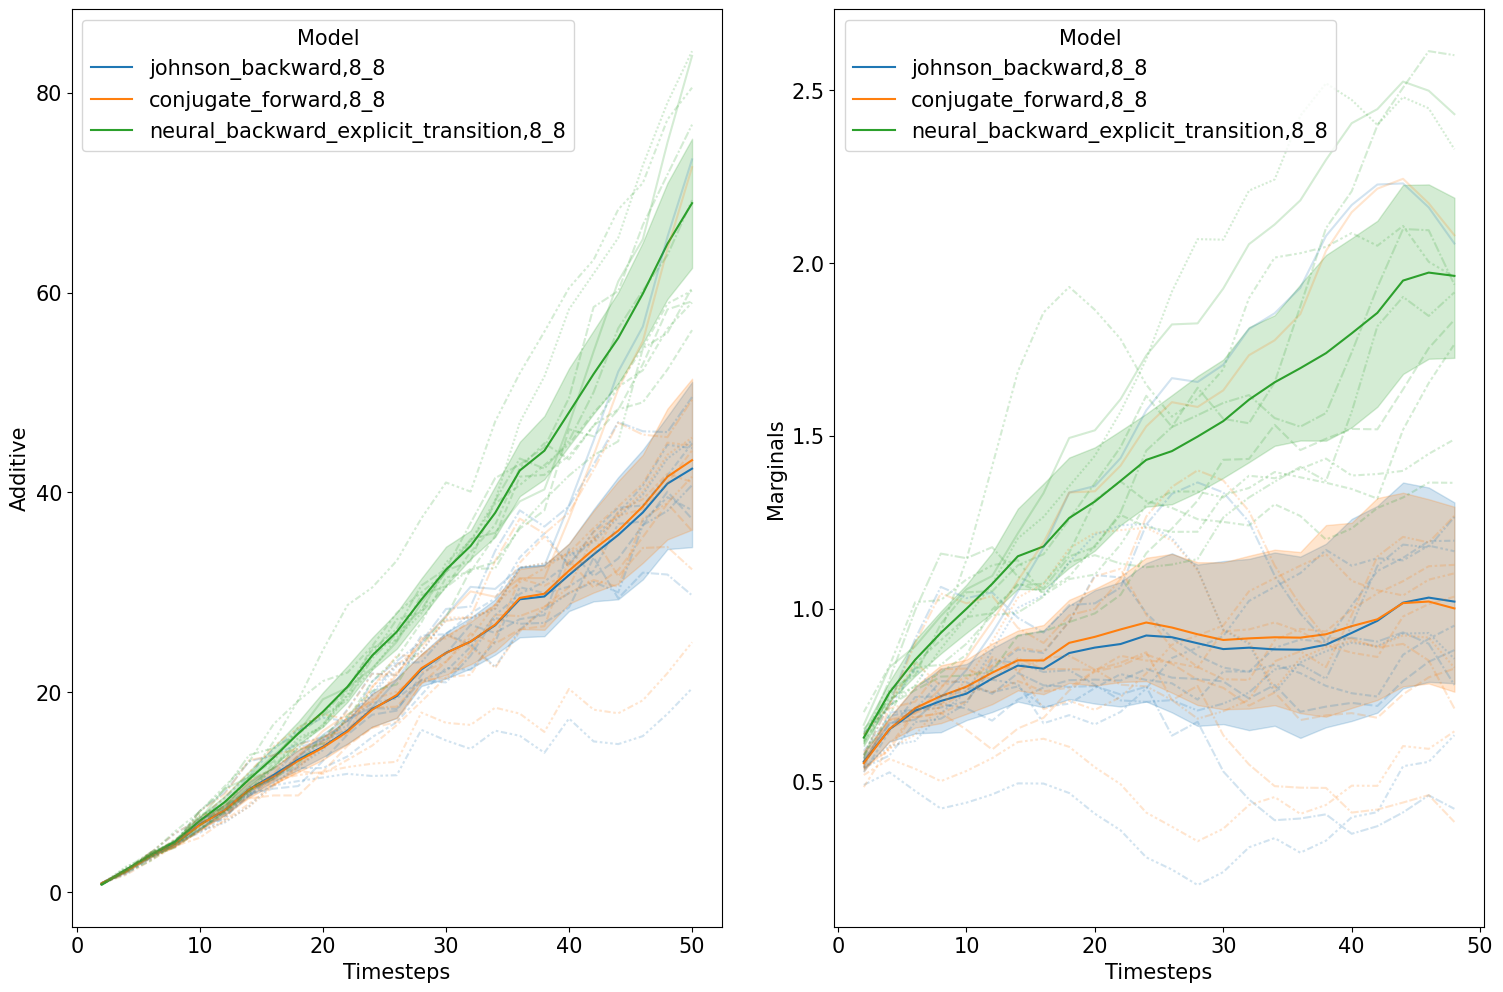

In [17]:
errors_all_models = []
for nb, model in enumerate(q_models):
  errors_all_models.append(errors_1st_moment(smc_paths, vi_marginals[nb], timesteps))

additive_dfs, marginals_dfs = plot_errors_multiple_models(q_models, errors_all_models)

# Experiment 2: training and evaluting on multiple sequences for the Conjugate Backward model

In [18]:
date = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
load=False
individual_params_per_seq = True
exp_path = f'experiments/eval_multiple_seqs/{date}'
# exp_path = 'experiments/eval_multiple_seqs/2023_07_28__14_20_53'
p_model = 'chaotic_rnn'
num_seqs = 50
seq_length = 500
n_bootstrap = 10_000
n_ffbsi = 50
d_x, d_y = 5,5
num_epochs_vi_learning = 1_000
key = jax.random.PRNGKey(0)

p_args = set_p_args(load, p_model, seq_length, n_bootstrap, n_ffbsi, exp_path, d_x, d_y)
key, key_theta, key_seqs = jax.random.split(key, 3)
p, theta = get_generative_model(p_args, key_theta)
xs, ys = get_sequences(key_seqs, p, theta, p_args, num_seqs, load, exp_path, '')

In [19]:
key, key_smc = jax.random.split(key, 2)
timesteps = get_timesteps(p_args, num_eval_points=25)
smc_paths = get_smc_paths(key_smc, p, theta, timesteps, ys, load, exp_path)

Computing FFBSi smoothing marginals...


100%|██████████| 50/50 [29:45<00:00, 35.71s/it]


In [20]:
q_model = 'johnson_backward,100'
num_epochs_vi = 1000
q_args = set_q_args(load, exp_path, num_epochs_vi, p_args, model)
key, key_vi = jax.random.split(key, 2)
q, params_q = get_params_q(key_vi, p, theta, p_args, q_args, (xs, ys), load, exp_path, individual_params_per_seq)
vi_marginals = get_vi_marginals(q, params_q, q_args, ys, timesteps, load, exp_path)
get_vi_backwd_params = get_vi_backwd_params(q, params_q, ys)    

Setting up potentials from linear Gaussian ParametricKernel.
Num params: 444
USING AUTODIFF ON BACKWARD BATCH ELBO.


Running for 1,000 iterations:  40%|████      | 400/1000 [03:42<06:04,  1.64it/s]